https://www.kaggle.com/seshadrikolluri/understanding-the-problem-and-some-sample-paths


https://www.kaggle.com/thexyzt/xyzt-s-visualizations-and-various-tsp-solvers


https://www.kaggle.com/theoviel/greedy-reindeer-starter-code

# Travelling Santa: métodos heurísticos

#### TSP com penalização

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [2]:
df_cities = pd.read_csv('cities.csv')
df_cities.head()

CityId            X            Y
0       0   316.836739  2202.340707
1       1  4377.405972   336.602082
2       2  3454.158198  2820.053011
3       3  4688.099298  2935.898056
4       4  1010.696952  3236.750989

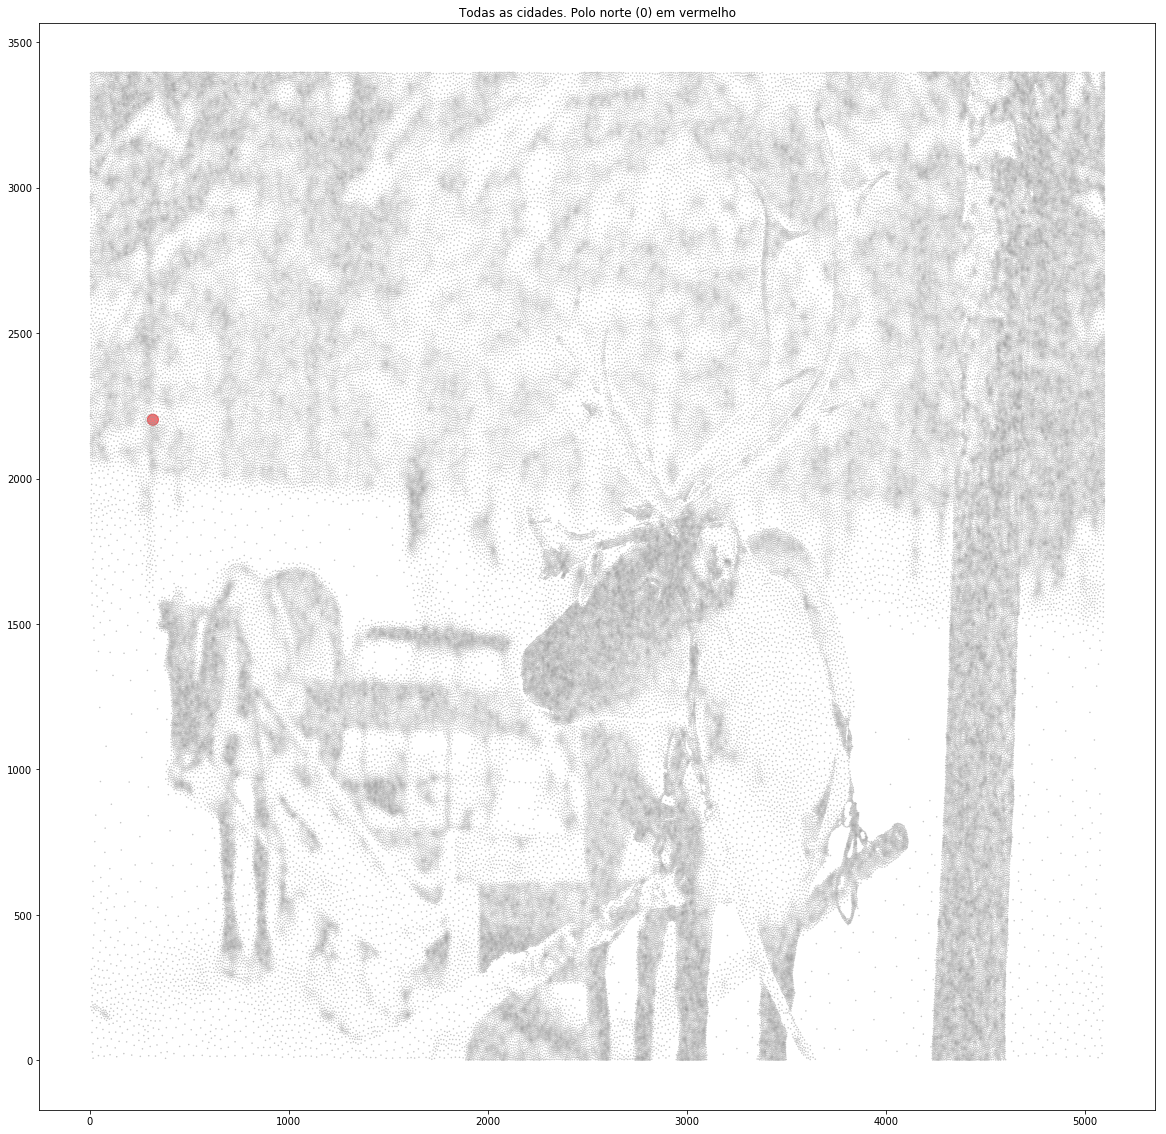

In [3]:
fig = plt.figure(figsize=(20,20))
#cmap, norm = from_levels_and_colors([0.0, 0.5, 1.5], ['red', 'black'])
plt.scatter(df_cities['X'],df_cities['Y'],marker = '.',c=(df_cities.CityId != 0).astype(int), cmap='Set1', alpha = 0.6, s = 500*(df_cities.CityId == 0).astype(int)+1)
plt.title("Todas as cidades. Polo norte (0) em vermelho")
plt.show()

In [3]:
def eratosthenes(n):
    primes = [True for i in range(n+1)] # Start assuming all numbers are primes
    primes[0] = False # 0 is not a prime
    primes[1] = False # 1 is not a prime
    for i in range(2,int(np.sqrt(n)) + 1):
        if primes[i]:
            k = 2
            while i*k <= n:
                primes[i*k] = False
                k += 1
    return(primes)
prime_cities = eratosthenes(max(df_cities.CityId))

In [4]:
df_cities[prime_cities][:10]

CityId            X            Y
2        2  3454.158198  2820.053011
3        3  4688.099298  2935.898056
5        5  2474.230877  1435.514651
7        7  3408.887685   199.585793
11      11  2052.116500   578.293526
13      13   965.611152  1067.734281
17      17  4313.207563  2800.438423
19      19  3033.179607   515.217613
23      23  3633.815728  2889.995167
29      29   793.107933  1250.697907

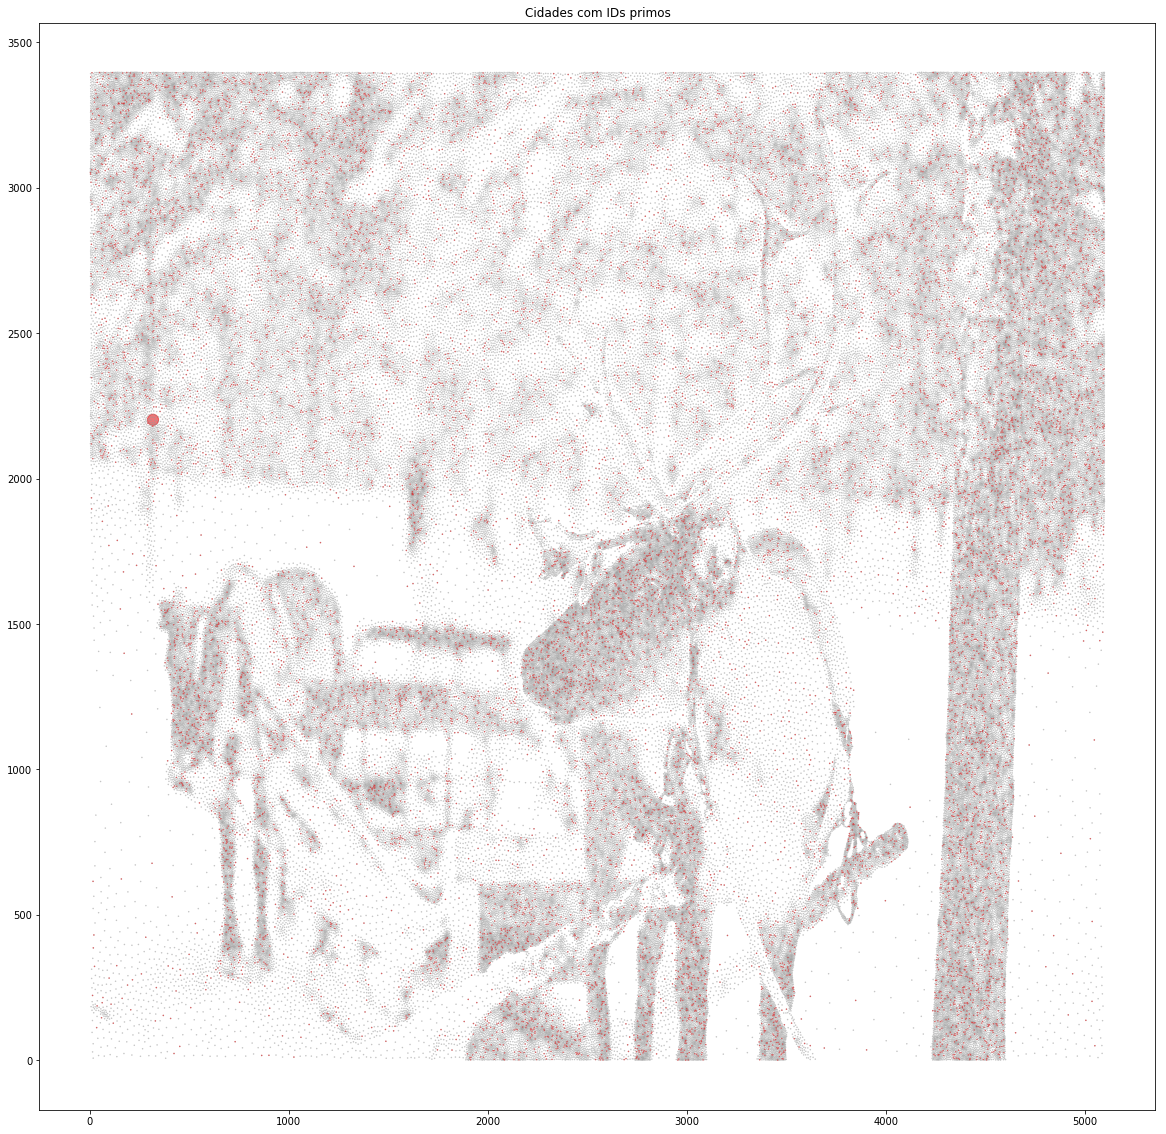

In [89]:
fig = plt.figure(figsize=(20,20))
#cmap, norm = from_levels_and_colors([0.0, 0.5, 1.5], ['red', 'black'])
plt.scatter(df_cities['X'],df_cities['Y'],marker = '.',c=(df_cities.CityId != 0).astype(int), cmap='Set1', alpha = 0.6, s = 500*(df_cities.CityId == 0).astype(int)+1)
plt.scatter(df_cities[prime_cities]['X'],df_cities[prime_cities]['Y'],marker = '.',c=(df_cities[prime_cities].CityId != 0).astype(int), cmap='Set1', alpha = 0.6, s = 500*(df_cities[prime_cities].CityId == 0).astype(int)+1)
plt.title("Cidades com IDs primos")
plt.show()

In [5]:
def total_distance(dfcity,path):
    prev_city = path[0]
    total_distance = 0
    step_num = 1
    for city_num in path[1:]:
        next_city = city_num
        total_distance = total_distance + \
            np.sqrt(pow((dfcity.X[city_num] - dfcity.X[prev_city]),2) + pow((dfcity.Y[city_num] - dfcity.Y[prev_city]),2)) * \
            (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
        prev_city = next_city
        step_num = step_num + 1
    return total_distance

---

## Nearest Neighbour sem levar em conta a penalização no cálculo do path

In [90]:
def nearest_neighbour():
    cities = df_cities
    ids = cities.CityId.values[1:]
    xy = np.array([cities.X.values, cities.Y.values]).T[1:]
    path = [0,]
    while len(ids) > 0:
        last_x, last_y = cities.X[path[-1]], cities.Y[path[-1]]
        dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
        nearest_index = dist.argmin()
        path.append(ids[nearest_index])
        ids = np.delete(ids, nearest_index, axis=0)
        xy = np.delete(xy, nearest_index, axis=0)
    path.append(0)
    return path

In [91]:
nnpath = nearest_neighbour()
print('Total distance with the Nearest Neighbor path '+  "is {:,}".format(total_distance(df_cities,nnpath)))

Total distance with the Nearest Neighbor path is 1,812,602.1861388374


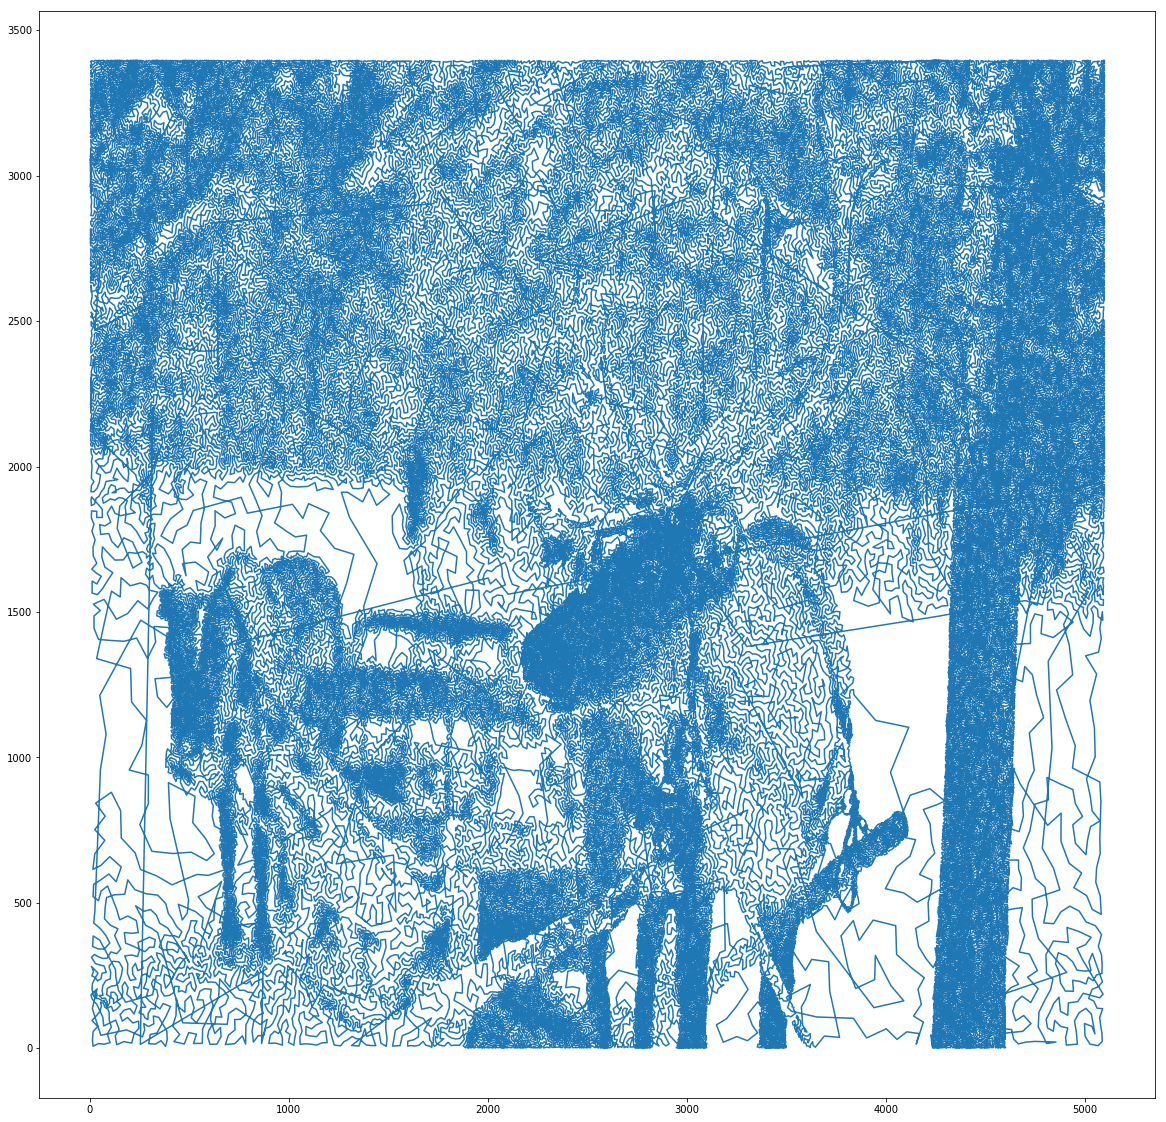

In [92]:
df_path_nn = pd.DataFrame({'CityId':nnpath}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path_nn['X'], df_path_nn['Y'])

---

## NN levando em conta a penalização no cálculo do path
###### Penalização aproximada colocando-a a cada nove passos, para aproximar à penalização real

In [32]:
primes = np.array(eratosthenes(max(df_cities.CityId))).astype(int)
df_cities['Prime'] = primes

In [66]:
print(df_cities.head())
penalization = 0.1 * (1 - primes) + 1

   CityId            X            Y  Prime
0       0   316.836739  2202.340707      0
1       1  4377.405972   336.602082      0
2       2  3454.158198  2820.053011      1
3       3  4688.099298  2935.898056      1
4       4  1010.696952  3236.750989      0


In [45]:
def dist_matrix(coords, i, penalize=False):
    begin = np.array([df_cities.X[i], df_cities.Y[i]])[:, np.newaxis]
    mat =  coords - begin
    if penalize:
        return np.linalg.norm(mat, ord=2, axis=0) * penalization
    else:
        return np.linalg.norm(mat, ord=2, axis=0)

def get_next_city(dist, avail):
    return avail[np.argmin(dist[avail])]

In [67]:
coordinates = np.array([df_cities.X, df_cities.Y])
current_city = 0
left_cities = np.array(df_cities.CityId)[1:]
path = [0]
stepNumber = 1

In [68]:
t0 = time()

while left_cities.size > 0:
    if stepNumber % 10000 == 0: # Progresso do algoritmo
        print(f"Passaram-se {(time() - t0)//60} min - Faltam {left_cities.size} cidades")
    # Computa o nono passo como mais caro para tentar priorizar buscar o primo mais próximo, se ainda compensar
    favorize_prime = (stepNumber % 10 == 9)
    # Faz a matriz de distâncias
    distances = dist_matrix(coordinates, current_city, penalize=favorize_prime)
    # Vai para a cidade mais próxima da que ainda não foram visitadas
    current_city = get_next_city(distances, left_cities)
    # Atualiza as não visitadas
    left_cities = np.setdiff1d(left_cities, np.array([current_city]))
    # Coloca a cidade atual no path
    path.append(current_city)
    stepNumber += 1
    
print(f"Loop lasted {(time() - t0) // 60} minutes ")

Time elapsed : 1.0 min - Number of cities left : 187769
Time elapsed : 3.0 min - Number of cities left : 177769
Time elapsed : 5.0 min - Number of cities left : 167769
Time elapsed : 7.0 min - Number of cities left : 157769
Time elapsed : 9.0 min - Number of cities left : 147769
Time elapsed : 10.0 min - Number of cities left : 137769
Time elapsed : 12.0 min - Number of cities left : 127769
Time elapsed : 13.0 min - Number of cities left : 117769
Time elapsed : 14.0 min - Number of cities left : 107769
Time elapsed : 16.0 min - Number of cities left : 97769
Time elapsed : 17.0 min - Number of cities left : 87769
Time elapsed : 18.0 min - Number of cities left : 77769
Time elapsed : 19.0 min - Number of cities left : 67769
Time elapsed : 20.0 min - Number of cities left : 57769
Time elapsed : 21.0 min - Number of cities left : 47769
Time elapsed : 22.0 min - Number of cities left : 37769
Time elapsed : 23.0 min - Number of cities left : 27769
Time elapsed : 24.0 min - Number of cities l

In [69]:
path.append(0)

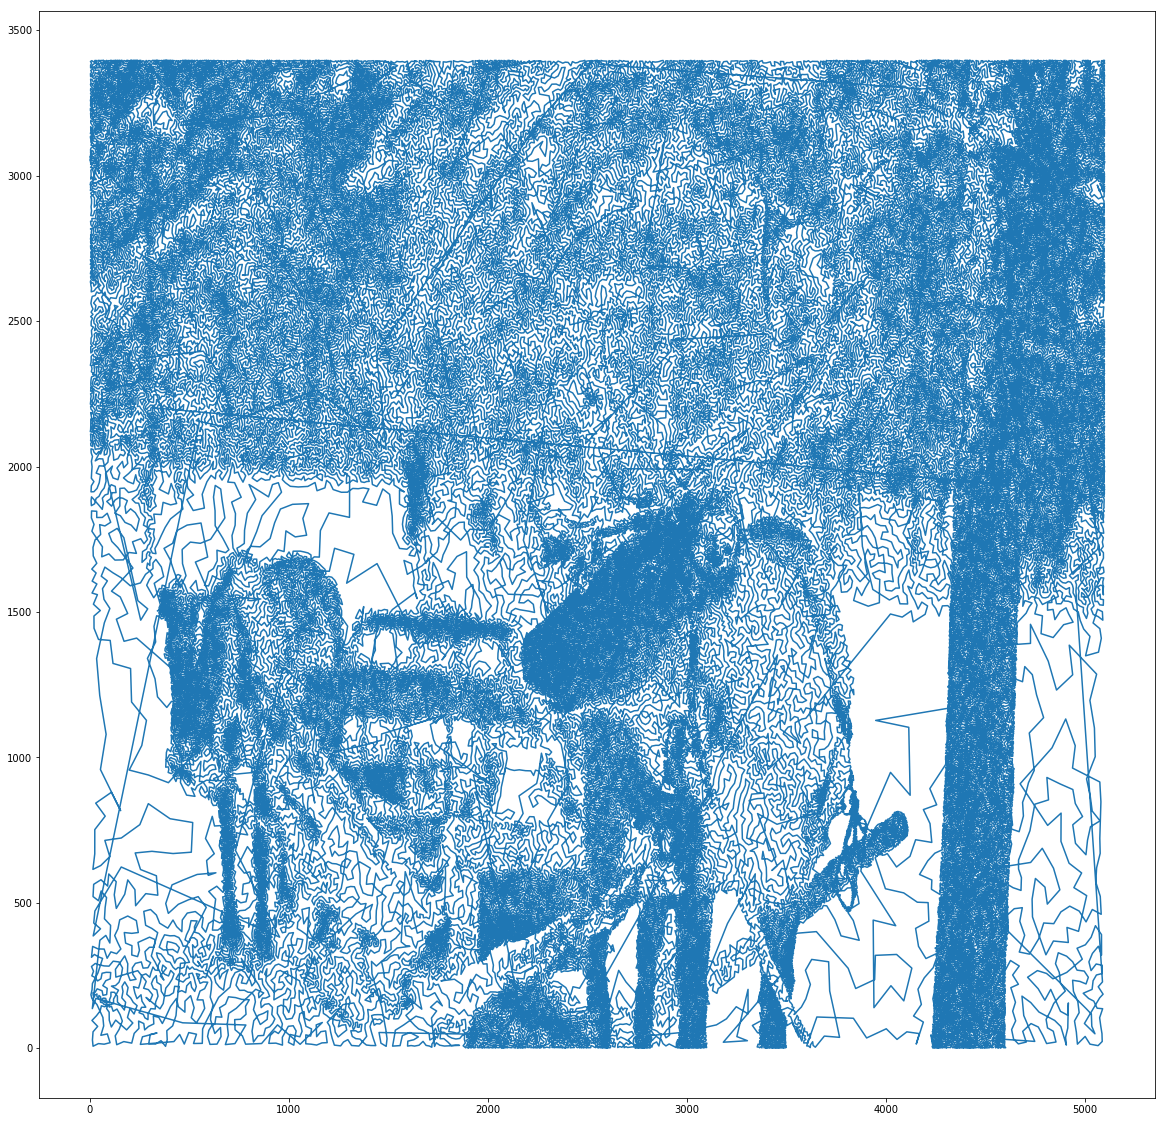

In [74]:
df_path = pd.DataFrame({'CityId':path}).merge(df_cities,how = 'left')
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(df_path['X'], df_path['Y'])

In [71]:
print('Total distance with the greedy path '+  "is {:,}".format(total_distance(df_cities,path)))

Total distance with the greedy path is 1,811,964.6610175867


---

## Clustering e rodando NN dentro dos clusters
https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
# K-Means ou DBScan?

---

In [6]:
def test_prime(num): # essa função retorna True se o número for primo. ela só testa um número por vez
    if (num == 1):
        return False
    elif (num == 2):
        return True
    else:
        for i in range(2,num):
            if (num % i == 0):
                return False
        return True

In [7]:
def proc(ident,xy):
    last_x, last_y = cities.X[ident], cities.Y[ident]
    dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
    return dist[np.argpartition(dist,2)][1]

In [8]:
def find_nearest(ident,xy,pxy,ids,prime=False):
    last_x, last_y = cities.X[ident], cities.Y[ident]
    dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
    pdist = ((pxy-np.array([last_x,last_y]))**2).sum(-1)
    if prime:
        nearest_index = dist.argmin()
        if not test_prime(ids[nearest_index]):
            d = dist[nearest_index]
            nearest_prime = pdist.argmin()
            p = dist[nearest_prime]
            prox = 1.1*proc(ids[nearest_index],xy)
            ppr = proc(ids[nearest_prime],xy)
            if (d+prox)>=(p+ppr):
                nearest_index = dist.index(pdist[nearest_prime])
                pxy = np.delete(pxy, nearest_prime, axis=0)
    else:
        nearest_index = dist.argmin()
    ids = np.delete(ids, nearest_index, axis=0)
    xy = np.delete(xy, nearest_index, axis=0)
    return nearest_index,ids,xy,pxy

In [39]:
def tent2():
    cities = df_cities
    ids = cities.CityId.values[1:]
    xy = np.array([cities.X.values, cities.Y.values]).T[1:]
    pxy = np.array([cities[prime_cities].X.values, cities[prime_cities].Y.values]).T[1:]
    path = [0,]
    step = 1
    while len(ids) > 0:
        if (step+1)%10 != 0:
            nearest_index,ids,xy,pxy = find_nearest(path[-1],xy,pxy,ids,prime=False)
            step += 1
            path.append(ids[nearest_index])
        else:
            nearest_index,ids,xy,pxy = find_nearest(path[-1],xy,pxy,ids,prime=True)
            step += 1
            path.append(ids[nearest_index])
            # print(len(ids))
    path.append(0)
    return path

In [26]:
cities = df_cities
ids = cities.CityId.values[1:]
xy = np.array([cities.X.values, cities.Y.values]).T[1:]
pxy = np.array([cities[prime_cities].X.values, cities[prime_cities].Y.values]).T[1:]
path = [0,]
step = 1

while len(ids) > 0:
    if (step+1)%10 != 0:
        nearest_index,ids,xy,pxy = find_nearest(path[-1],xy,pxy,ids,prime=False)
        print(nearest_index)
        step += 1
        path.append(ids[nearest_index])
    else:
        nearest_index,ids,xy,pxy = find_nearest(path[-1],xy,pxy,ids,prime=True)
        step += 1
        path.append(ids[nearest_index])
        # print(len(ids))
path.append(0)

78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
78933
7893

KeyboardInterrupt: 

In [13]:
cities = df_cities
ids = cities.CityId.values[1:]
xy = np.array([cities.X.values, cities.Y.values]).T[1:]
pxy = np.array([cities[prime_cities].X.values, cities[prime_cities].Y.values]).T[1:]

last_x,last_y = cities.X[197768],cities.Y[197768]
dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
print(dist[np.argpartition(dist,2)][1])
# find_nearest(5,xy,ids,prime=True)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [28]:
print(path[-5:])
print(find_nearest(78933,xy,pxy,ids,prime=False))
print(ids[78932])
print(len(ids))

[79203, 79204, 79205, 79206, 79207]
(78932, array([     1,      2,      3, ..., 197766, 197767, 197768], dtype=int64), array([[4377.40597217,  336.60208217],
       [3454.15819771, 2820.05301125],
       [4688.09929763, 2935.89805581],
       ...,
       [4775.8898741 , 3103.84622792],
       [2994.23095453, 1931.76434369],
       [1354.7647783 , 3218.10062536]]), array([[4688.09929763, 2935.89805581],
       [2474.23087706, 1435.51465103],
       [3408.8876851 ,  199.58579311],
       ...,
       [3916.07467347, 2809.51844079],
       [1390.80520408,  899.59856379],
       [2994.23095453, 1931.76434369]]))
78933
197494


In [42]:
tpath = tent2()

IndexError: index 78933 is out of bounds for axis 0 with size 78933

In [28]:
print('Total distance with the attempted path '+  "is {:,}".format(total_distance(df_cities,tpath)))

NameError: name 'tpath' is not defined

---

In [34]:
# pegar o NNeighbours e testar se o passo mais próximo for primo. se for, testar se é um passo que vai ser mais caro
# Se for, testar o que compensa mais: ir pro primo mais próximo ou ir pro mais próximo normal, dado o aumento de custo
# aí testar de novo o que compensa mais
def tent():
    cities = df_cities
    ids = cities.CityId.values[1:]
    xy = np.array([cities.X.values, cities.Y.values]).T[1:]
    path = [0,]
    step = 1
    while len(ids) > 0:
        last_x, last_y = cities.X[path[-1]], cities.Y[path[-1]]
        dist = ((xy - np.array([last_x, last_y]))**2).sum(-1)
        if step<10: # começando os testes
            nearest_index = dist.argmin()
            path.append(ids[nearest_index])
            step += 1
        else:
            ps = list()
            ds = list()
            try:
                dists = np.argpartition(dist,10)
            except AttributeError:
                dists = np.argpartition(dist,len(ids))
            for x in dists:
                if test_prime(x):
                    ps.append(dist[x])
                else:
                    ds.append(dist[x]*1.1)
            try:
                pmin = min(ps)
            except ValueError:
                pmin = 100000000000
            try:
                dmin = min(ds)
            except ValueError:
                dmin = 100000000000
            distance = min([pmin,dmin])
            nearest_index = np.where(dist==distance)
            try:
                path.append(ids[nearest_index])
            except IndexError:
                print(len(ids))
                break
            step = 1
        ids = np.delete(ids, nearest_index, axis=0)
        xy = np.delete(xy, nearest_index, axis=0)
    path.append(0)
    return path

In [35]:
tpath = tent() # eita.... não sei o que deu não
print('Total distance with the attempted path '+  "is {:,}".format(total_distance(df_cities,tpath)))

ValueError: operands could not be broadcast together with shapes (197759,2) (2,0) 

In [17]:
from sklearn.neighbors import NearestNeighbors

In [19]:
nneigh = NearestNeighbors(n_neighbors=10)
nneigh.fit(df_cities)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [26]:
nneigh.kneighbors(df_cities,return_distance=False)

array([[     0,     86,    201, ...,    208,     73,    389],
       [     1,     63,     57, ...,    155,     59,    184],
       [     2,     91,    106, ...,     85,    211,     66],
       ...,
       [197766, 197671, 197673, ..., 197541, 197602, 197619],
       [197767, 197640, 197567, ..., 197576, 197596, 197674],
       [197768, 197635, 197597, ..., 197390, 197656, 197540]], dtype=int64)

In [27]:
from scipy.spatial import KDTree

In [32]:
kd = KDTree(df_cities)

In [20]:
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
b=[0,1,2,3,4,5,6,7,8]
c=[9,10,11,12]
np.array([np.array(b).argmin(),np.argmin(c).argmin()]).argmin()

0

In [21]:
p=[]
min(p)

ValueError: min() arg is an empty sequence